<a href="https://colab.research.google.com/github/cboyda/MachineLearning/blob/main/Capstone_Team1_W23_merged_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Project Capstone**

Team member names:

*  Brett Adams
*  Cailenys Leslie
*  Clinton Boyda 
*  Ram Dershan
*  Tanvir Hossain

Dataset: 
[New York City Airbnb Open Data](https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data) plus additional dataset for additional features

In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import model_selection
from  sklearn import neighbors
import plotly.graph_objects as go
import math
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore") # disable warnings when making remote calls

#   **Project Objective: Attract hosts to Airbnb by predicting price to maximize revenue** 

# **Load Dataset**

In [2]:
# Connect to Dataset

#original filename = "https://raw.githubusercontent.com/cboyda/MachineLearning/main/AB_NYC_2019.csv"
#df = pd.read_csv(filename)

# load both data sets in
original = "https://raw.githubusercontent.com/cboyda/MachineLearning/main/AB_NYC_2019.csv"
df_original = pd.read_csv(original)
additional = "https://raw.githubusercontent.com/cboyda/MachineLearning/main/full_nyc_dataset_cleaned_table-1.csv"
df_additional = pd.read_csv(additional)

In [3]:
df_original.shape

(48895, 16)

In [4]:
df_additional.shape

(41533, 7)

In [5]:
# Merge the two datasets with an inner join, validate that no duplicate id values exist for a one to one join

#Choice 1: original dataset
#df = df_original
# OR
df = pd.merge(df_original, df_additional, how = "inner", on = "id", validate="one_to_one", suffixes=("_original","_additional"))

df.shape

(16005, 22)

In [6]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type_original', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'property_type', 'room_type_additional',
       'accommodates', 'bathrooms_text', 'bedrooms', 'beds'],
      dtype='object')

In [7]:
df.head(5)

id                                            name  host_id  host_name  \
0  2595                           Skylit Midtown Castle     2845   Jennifer   
1  5121                                 BlissArtsSpace!     7356      Garon   
2  5178                Large Furnished Room Near B'way      8967   Shunichi   
3  5203              Cozy Clean Guest Room - Family Apt     7490  MaryEllen   
4  5803  Lovely Room 1, Garden, Best Area, Legal rental     9744     Laurie   

  neighbourhood_group       neighbourhood  latitude  longitude  \
0           Manhattan             Midtown  40.75362  -73.98377   
1            Brooklyn  Bedford-Stuyvesant  40.68688  -73.95596   
2           Manhattan      Hell's Kitchen  40.76489  -73.98493   
3           Manhattan     Upper West Side  40.80178  -73.96723   
4            Brooklyn         South Slope  40.66829  -73.98779   

  room_type_original  price  ...  last_review  reviews_per_month  \
0    Entire home/apt    225  ...   2019-05-21               0.38   
1       Private room     60  ...   2017-10-05               0.40   
2       Private room     79  ...   2019-06-24               3.47   
3       Private room     79  ...   2017-07-21               0.99   
4       Private room     89  ...   2019-06-24               1.34   

  calculated_host_listings_count  availability_365  \
0                              2               355   
1                              1                 0   
2                              1               220   
3                              1                 0   
4                              3               314   

                 property_type  room_type_additional accommodates  \
0           Entire rental unit       Entire home/apt            1   
1  Private room in rental unit          Private room            2   
2  Private room in rental unit          Private room            2   
3  Private room in rental unit          Private room            1   
4    Private room in townhouse          Private room            2   

  bathrooms_text  bedrooms beds  
0         1 bath       NaN  1.0  
1            NaN       1.0  1.0  
2         1 bath       1.0  1.0  
3  1 shared bath       1.0  1.0  
4      1.5 baths       1.0  1.0  

[5 rows x 22 columns]

# **Clean Merged Dataset**

In [8]:
# Check shape after dropping examples
df.shape

(16005, 22)

In [9]:
df = df.drop(df[(df['property_type'] == 'Cave') | (df['property_type'] == 'Boat') | 
                (df['property_type'] == 'Floor') | (df['property_type'] == 'Private room in farm stay') |
                (df['property_type'] == 'Entire villa') | (df['property_type'] == 'Private room in houseboat') |
                (df['property_type'] == 'Private room in villa') | (df['property_type'] == 'Private room in tent') |
                (df['property_type'] == 'Houseboat')].index)

In [10]:
# assess new value counts for property_type
df['property_type'].value_counts()

Entire rental unit                    6975
Private room in rental unit           5153
Private room in home                   844
Entire home                            513
Entire condo                           418
Private room in townhouse              352
Entire loft                            326
Entire townhouse                       297
Private room in condo                  180
Shared room in rental unit             178
Private room in loft                   149
Entire guest suite                     133
Entire serviced apartment               98
Room in boutique hotel                  68
Room in hotel                           56
Private room in guest suite             37
Entire place                            33
Room in serviced apartment              24
Entire guesthouse                       19
Shared room in loft                     19
Private room                            18
Private room in resort                  17
Private room in bed and breakfast       14
Shared room

In [11]:
# extract the numerical values from the bathroom_text column for consideration 
df['bathrooms_text'].mask(df['bathrooms_text'] == 'Half-bath', 0.5, inplace=True)
df['bathrooms_text'].mask(df['bathrooms_text'] == 'Shared half-bath', 0.5, inplace=True)
df['bathrooms_text'].mask(df['bathrooms_text'] == 'Private half-bath', 0.5, inplace=True)
df['bathrooms'] = df['bathrooms_text'].str.extract(r'\b([\d.]+)\b')

In [12]:
# let's look closer at the property_type values, perhaps this can be simplified
print(df['property_type'].unique())
print("Number of property_type unique values:",df['property_type'].nunique())

['Entire rental unit' 'Private room in rental unit'
 'Private room in townhouse' 'Entire guest suite' 'Entire loft'
 'Private room in home' 'Entire condo' 'Private room in condo'
 'Private room in loft' 'Entire home' 'Entire townhouse'
 'Private room in bed and breakfast' 'Entire guesthouse'
 'Private room in guest suite' 'Room in boutique hotel'
 'Shared room in rental unit' 'Shared room in home' 'Private room'
 'Entire place' 'Entire serviced apartment' 'Private room in guesthouse'
 'Room in serviced apartment' 'Entire cottage' 'Shared room in loft'
 'Private room in serviced apartment' 'Entire bungalow' 'Room in hotel'
 'Shared room in townhouse' 'Private room in hostel'
 'Private room in bungalow' 'Shared room in condo'
 'Private room in resort' 'Shared room in floor' 'Private room in floor'
 'Tiny home' 'Entire home/apt' 'Shared room in guest suite'
 'Room in resort' 'Room in aparthotel' 'Shared room in guesthouse'
 'Room in bed and breakfast']
Number of property_type unique value

In [13]:
df['property_type'] = df.property_type.str.replace(r'(^.*Private room.*$)', 'Private Room')
#df.property_type.replace(['Private room in rental unit', 'female'], [1, 0], inplace=True)
#replace_property_values = {'Small' : 1, 'Medium' : 2, 'High' : 3 }
#replace_property_values = df.loc[df['property_type'].str.contains('Private room', case=False), 'property_type'] = 'Private Room'

In [14]:
df['property_type'] = df.property_type.str.replace(r'(^.*Entire.*$)', 'Entire Unit')

In [15]:
df['property_type'] = df.property_type.str.replace(r'(^.*Shared room.*$)', 'Shared Room')

In [16]:
df['property_type'] = df.property_type.str.replace(r'(^.*Room in.*$)', 'Room In')

In [17]:
df['property_type'].value_counts()

Entire Unit     8826
Private Room    6780
Shared Room      220
Room In          154
Tiny home          6
Name: property_type, dtype: int64

In [18]:
print(df['property_type'].unique())
print("Number of property_type unique values:",df['property_type'].nunique())

['Entire Unit' 'Private Room' 'Room In' 'Shared Room' 'Tiny home']
Number of property_type unique values: 5


In [19]:
# Convert bathroom to float type
df['bathrooms'] = df['bathrooms'].astype(float)

In [20]:
# drop bathroom_text, beds, and duplicated room_type column
df.drop(['bathrooms_text', 'room_type_additional', 'beds'], axis = 1, inplace = True)

In [21]:
# drop suffix from room_type_original
df = df.rename(columns = {'room_type_original' : 'room_type'})

In [22]:
df['room_type'].value_counts()

Entire home/apt    8803
Private room       6963
Shared room         220
Name: room_type, dtype: int64

For bedrooms and bathrooms with null values, fill with zero as properties can have no bedrooms or bathrooms

In [23]:
df[['bedrooms', 'bathrooms']] = df[['bedrooms', 'bathrooms']].fillna(value=0)

In [24]:
df.shape

(15986, 20)

# **Consider Required Features**

In [25]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'property_type', 'accommodates', 'bedrooms',
       'bathrooms'],
      dtype='object')

In [26]:
# how many of each unique value exists in our cleaned data?
for col in df:
  print("\nFor column", col)
  print(df[col].value_counts(sort=True))


For column id
2595        1
21305125    1
21280280    1
21282152    1
21283357    1
           ..
9365176     1
9365502     1
9366256     1
9366707     1
36487245    1
Name: id, Length: 15986, dtype: int64

For column name
Loft Suite @ The Box House Hotel                      11
New york Multi-unit building                           8
Cozy Brooklyn Apartment                                4
Private room in Williamsburg                           4
WEST VILLAGE Bohemian flat in neo-Tudor town house     4
                                                      ..
Chelsea studio                                         1
Upper west Apt close to Central Pk                     1
High Luxury Thanksgiving Stay                          1
Stylish apartment in Sunset Park Brooklyn              1
Trendy duplex in the very heart of Hell's Kitchen      1
Name: name, Length: 15795, dtype: int64

For column host_id
107434423    120
61391963      55
137358866     53
120762452     50
7503643       35
    

In [27]:
#define clean as duplicate
df_clean = df.copy()

In [28]:
# drop all columns not necessary
# over simplifying for our first iteration

#original 
#df_clean.drop(['id','name','host_name','number_of_reviews','last_review','reviews_per_month',
#         'calculated_host_listings_count','id','host_id','latitude','longitude'], axis=1, inplace = True)

# keep latitude and longitude for mapping
df_clean.drop(['id','name','host_name','number_of_reviews','last_review','reviews_per_month',
         'calculated_host_listings_count','id','host_id'], axis=1, inplace = True)

#merged data need to drop 'index' as well

In [29]:
df.shape

(15986, 20)

# **Data Verification (Nulls & Duplicates)**

In [30]:
df_clean.duplicated().any()

False

In [31]:
# any duplicates in the data?
duplicate_rows = df_clean.duplicated()
df_no_dups = df_clean[~duplicate_rows]
print ("There are " + str(duplicate_rows.sum()) + " duplicate rows in our dataframe that need to be considered.")

There are 0 duplicate rows in our dataframe that need to be considered.


In [32]:
# really only needed if duplicate_rows > 0
df_clean = df_no_dups
#df_clean.reset_index(inplace=True)

In [33]:
# check for null values
df_clean.isnull().sum()

neighbourhood_group    0
neighbourhood          0
latitude               0
longitude              0
room_type              0
price                  0
minimum_nights         0
availability_365       0
property_type          0
accommodates           0
bedrooms               0
bathrooms              0
dtype: int64

# **Manage Zero Values**

In [34]:
df_clean.head(10)

neighbourhood_group       neighbourhood  latitude  longitude  \
0           Manhattan             Midtown  40.75362  -73.98377   
1            Brooklyn  Bedford-Stuyvesant  40.68688  -73.95596   
2           Manhattan      Hell's Kitchen  40.76489  -73.98493   
3           Manhattan     Upper West Side  40.80178  -73.96723   
4            Brooklyn         South Slope  40.66829  -73.98779   
5            Brooklyn        Williamsburg  40.70837  -73.95352   
6            Brooklyn         Fort Greene  40.69169  -73.97185   
7            Brooklyn        Williamsburg  40.71842  -73.95718   
8            Brooklyn  Bedford-Stuyvesant  40.68371  -73.94028   
9           Manhattan      Hell's Kitchen  40.76715  -73.98533   

         room_type  price  minimum_nights  availability_365 property_type  \
0  Entire home/apt    225               1               355   Entire Unit   
1     Private room     60              45                 0  Private Room   
2     Private room     79               2               220  Private Room   
3     Private room     79               2                 0  Private Room   
4     Private room     89               4               314  Private Room   
5  Entire home/apt    140               2                46   Entire Unit   
6  Entire home/apt    215               2               321   Entire Unit   
7  Entire home/apt    299               3                 0   Entire Unit   
8  Entire home/apt    120               2               233   Entire Unit   
9  Entire home/apt    150              10                75   Entire Unit   

   accommodates  bedrooms  bathrooms  
0             1       0.0        1.0  
1             2       1.0        0.0  
2             2       1.0        1.0  
3             1       1.0        1.0  
4             2       1.0        1.5  
5             3       0.0        1.0  
6             4       1.0        1.0  
7             4       0.0        1.0  
8             5       1.0        1.0  
9             2       0.0        1.0

In [35]:
df_clean.shape

(15986, 12)

Manage data with rental price = zero.

In [36]:
# log of zero fails so we count how many have zero, if small, then drop
df_clean.loc[df_clean.price  == 0, 'price'].count()

5

In [37]:
zero_price = df_clean.loc[df_clean.price  == 0, 'price'].index

In [38]:
# zero price rows is low, dropping
df_clean.drop(zero_price,axis=0,inplace=True)

In [39]:
df_clean.shape

(15981, 12)

Consider managing data where minimum nights = zero.

In [40]:
# log of zero fails so we count how many have zero, if small, then drop
count_zero_min_nights = df_clean.loc[df_clean.minimum_nights  == 0, 'minimum_nights'].count()
count_zero_min_nights

0

In [41]:
# set index for easier data management
zero_minimum_nights = df_clean.loc[df_clean.minimum_nights  == 0, 'minimum_nights'].index

In [42]:
# zero price rows is low, dropping
if count_zero_min_nights > 0:
  df_clean.drop(zero_minimum_nights,axis=0,inplace=True)

# **Data Cleaning**


In [43]:
df_clean.shape

(15981, 12)

In [44]:
df_clean.columns

Index(['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'price', 'minimum_nights', 'availability_365',
       'property_type', 'accommodates', 'bedrooms', 'bathrooms'],
      dtype='object')

In [45]:
zero_availability = df_clean.loc[df_clean.availability_365 == 0, 'availability_365'].index
# zero availability means unit is NOT available so best drop from out model
df_clean.drop(zero_availability,axis=0,inplace=True)

DROP units that are simply not able to be rented. This includes availability = 0

In [46]:
df_clean.shape

(8621, 12)

In [47]:
# dropping availability_365 feature at this stage since it was a filter not a feature
df_clean.drop(['availability_365'], axis=1, inplace = True)

In [48]:
numeric_data = df_clean.select_dtypes(include=['int64', 'float64'])
categorical_data = df_clean.select_dtypes(exclude=[np.number])

In [49]:
numeric_data

latitude  longitude  price  minimum_nights  accommodates  bedrooms  \
0      40.75362  -73.98377    225               1             1       0.0   
2      40.76489  -73.98493     79               2             2       1.0   
4      40.66829  -73.98779     89               4             2       1.0   
5      40.70837  -73.95352    140               2             3       0.0   
6      40.69169  -73.97185    215               2             4       1.0   
...         ...        ...    ...             ...           ...       ...   
16000  40.69482  -73.86618     85               3             2       1.0   
16001  40.77192  -73.95369     95               1             2       1.0   
16002  40.63116  -73.92616    170               1             6       2.0   
16003  40.72585  -73.94001     54               6             2       1.0   
16004  40.76404  -73.98933     90               7             2       1.0   

       bathrooms  
0            1.0  
2            1.0  
4            1.5  
5            1.0  
6            1.0  
...          ...  
16000        1.0  
16001        1.0  
16002        1.0  
16003        1.0  
16004        2.0  

[8621 rows x 7 columns]

In [50]:
categorical_data

neighbourhood_group    neighbourhood        room_type property_type
0               Manhattan          Midtown  Entire home/apt   Entire Unit
2               Manhattan   Hell's Kitchen     Private room  Private Room
4                Brooklyn      South Slope     Private room  Private Room
5                Brooklyn     Williamsburg  Entire home/apt   Entire Unit
6                Brooklyn      Fort Greene  Entire home/apt   Entire Unit
...                   ...              ...              ...           ...
16000              Queens        Woodhaven  Entire home/apt   Entire Unit
16001           Manhattan  Upper East Side     Private room  Private Room
16002            Brooklyn        Flatlands  Entire home/apt   Entire Unit
16003            Brooklyn       Greenpoint     Private room  Private Room
16004           Manhattan   Hell's Kitchen     Private room  Private Room

[8621 rows x 4 columns]

In [51]:
# what are the unique values for each column?
# label can be category but others should be binary for simplicity
for col in df_clean:
    print(col, df_clean[col].unique(), df_clean[col].nunique() )

neighbourhood_group ['Manhattan' 'Brooklyn' 'Queens' 'Staten Island' 'Bronx'] 5
neighbourhood ['Midtown' "Hell's Kitchen" 'South Slope' 'Williamsburg' 'Fort Greene'
 'Bedford-Stuyvesant' 'Harlem' 'Flatbush' 'East Village'
 'Long Island City' 'Greenpoint' 'SoHo' 'Chelsea' 'Prospect Heights'
 'East Harlem' 'Washington Heights' 'Upper East Side' 'Upper West Side'
 'Carroll Gardens' 'West Village' 'Park Slope' 'Clinton Hill' 'Flatlands'
 'Boerum Hill' 'Sunnyside' 'St. George' 'Ridgewood' 'Morningside Heights'
 'Middle Village' 'Ditmars Steinway' 'Cobble Hill' 'Flatiron District'
 'Windsor Terrace' 'Lower East Side' 'Chinatown' 'Greenwich Village'
 'Clason Point' 'Eastchester' 'Crown Heights' 'Gowanus' 'Little Italy'
 'Kingsbridge' 'Astoria' 'Bushwick' 'Rockaway Beach' 'Forest Hills'
 'Murray Hill' 'University Heights' 'Kips Bay' 'Nolita' 'Allerton'
 'East New York' 'Emerson Hill' 'Bensonhurst' 'Shore Acres' 'Elmhurst'
 'Sunset Park' 'Arrochar' 'East Flatbush' 'Kensington' 'Woodside'
 'Pros

In [52]:
# how many of each unique value exists in our cleaned data?
for col in df_clean:
  print("\nFor column", col)
  print(df_clean[col].value_counts(sort=True))



For column neighbourhood_group
Brooklyn         3553
Manhattan        3308
Queens           1353
Bronx             303
Staten Island     104
Name: neighbourhood_group, dtype: int64

For column neighbourhood
Bedford-Stuyvesant    708
Harlem                567
Williamsburg          481
Bushwick              323
Hell's Kitchen        291
                     ... 
Silver Lake             1
Holliswood              1
South Beach             1
Howland Hook            1
Prince's Bay            1
Name: neighbourhood, Length: 206, dtype: int64

For column latitude
40.71515    5
40.71756    5
40.68497    5
40.71813    5
40.68683    5
           ..
40.64062    1
40.58859    1
40.58734    1
40.79610    1
40.72585    1
Name: latitude, Length: 6969, dtype: int64

For column longitude
-73.94034    6
-73.94628    5
-73.95231    5
-73.94288    5
-73.97683    5
            ..
-73.99581    1
-73.99819    1
-73.93069    1
-74.00344    1
-73.92616    1
Name: longitude, Length: 6393, dtype: int64

For colum

In [53]:
df_clean.dtypes

neighbourhood_group     object
neighbourhood           object
latitude               float64
longitude              float64
room_type               object
price                    int64
minimum_nights           int64
property_type           object
accommodates             int64
bedrooms               float64
bathrooms              float64
dtype: object

In [54]:
df.shape

(15986, 20)

In [55]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'property_type', 'accommodates', 'bedrooms',
       'bathrooms'],
      dtype='object')

# **Manage Extreme Values**

In [56]:
# BEFORE extreme values have been handled, view the ranges graphically
for column in df_clean.columns:
  fig = px.histogram(df_clean, x=column, marginal="box")
  fig.show()

Consider how to manage extreme values.

In [57]:
extreme_values = []
for column in numeric_data.columns:
  # Select the first quantile
  q1 = df[column].quantile(0.25)

  # Select the third quantile
  q3 = df[column].quantile(0.75)

  max = df[column].quantile(1)

  # Create a mask inbetween q1 & q3
  IQR = q3 - q1

  # Filtering the initial dataframe with a mask
  #filtered = df.query('(@q1 - 1.5 * @IQR) <= [column] <= (@q3 + 1.5 * @IQR)')
  # Filtering Values between Q1-1.5IQR and Q3+1.5IQR  

  #maximum outliers
  bottom_fence = 0 if (q1 - 1.5 * IQR) < 0 else q1 - 1.5 * IQR
  upper_fence = max if (q3 + 1.5 * IQR) > max else (q3 + 1.5 * IQR)
  #display(column, bottom_fence, upper_fence)
  extreme_values.append([column, bottom_fence, upper_fence])


In [58]:
  extreme_values

[['latitude', 40.575222499999995, 40.8762825],
 ['longitude', 0, -73.86789250000001],
 ['price', 0, 332.5],
 ['minimum_nights', 0, 11.0],
 ['accommodates', 0, 7.0],
 ['bedrooms', 1.0, 1.0],
 ['bathrooms', 1.0, 1.0]]

In [59]:
# lookup in extreme_values UPPER/LOWER FENCE values
def get_upperfence(name=''):
  for i in range(len(extreme_values)):
    if extreme_values[i][0] == name:
      return extreme_values[i][2]
    else:
      continue

def get_lowerfence(name=''):
  for i in range(len(extreme_values)):
    if extreme_values[i][0] == name:
      return extreme_values[i][1]
    else:
      continue

In [60]:
# calculate percentage of values over our extreme, if under 5% consider dropping
display ('Pricing percentage over extreme:')
(df_clean.loc[df_clean.price > get_upperfence('price'), 'price'].count() / df_clean.price.count()) * 100 

'Pricing percentage over extreme:'

6.820554460039438

In [61]:
# drop upperfence extreme prices
df_clean.drop(df_clean[df_clean['price'] > get_upperfence('price')].index, inplace = True)


In [62]:
# calculate percentage of values over our extreme, if under 5% consider dropping
display ('Minimum nights percentage over extreme:')
(df_clean.loc[df_clean.minimum_nights > get_upperfence('minimum_nights'), 'minimum_nights'].count() / df_clean.minimum_nights.count()) * 100 

'Minimum nights percentage over extreme:'

19.058882111290927

In [63]:
# NOT DROPPING minimum_nights because of high percentage
# drop upperfence extreme minimum nights
# df_clean.drop(df_clean[df_clean['minimum_nights'] > get_upperfence('minimum_nights')].index, inplace = True)

In [64]:
# drop upperfence extreme accomodations, if under 5% consider dropping
display ('Accomodates percentage over extreme:')
(df_clean.loc[df_clean.accommodates > get_upperfence('accommodates'), 'accommodates'].count() / df_clean.accommodates.count()) * 100 


'Accomodates percentage over extreme:'

1.991783891447778

In [65]:
df_clean.drop(df_clean[df_clean['accommodates'] > get_upperfence('accommodates')].index, inplace = True)

In [66]:
# AFTER extreme values dropped, how do histograms look now?
for column in df_clean.columns:
  fig = px.histogram(df_clean, x=column, marginal="box")
  fig.show()

# **Transformation of Data**

Price from graph needs correction, utilizing log of price to get a gaussian curve.

In [67]:
# view current price histogram
fig = px.histogram(df_clean, x=["price"], marginal="box")
fig.show()

In [68]:
# create feature transform price with log function
df_clean['log_price'] = np.log(df_clean['price'])

In [69]:
# view log_price histogram
fig = px.histogram(df_clean, x=["log_price"], marginal="box")
fig.show()

In [70]:
df_clean.dtypes

neighbourhood_group     object
neighbourhood           object
latitude               float64
longitude              float64
room_type               object
price                    int64
minimum_nights           int64
property_type           object
accommodates             int64
bedrooms               float64
bathrooms              float64
log_price              float64
dtype: object

# Price Distribution Visualizations

Looking at neighbourhood data...

In [141]:
fig = px.histogram(df_clean, x=df_clean.neighbourhood, marginal="box")
fig.show()

In [137]:
fig = px.histogram(df_clean, x=df_clean.neighbourhood)
fig.update_xaxes(categoryorder="total descending")
fig.update_traces(marker_color='#00A699')
fig.update_layout(width=700, height=600)
fig.show()

In [71]:
fig = px.histogram(df_clean, x=df_clean.neighbourhood_group)
fig.update_xaxes(categoryorder="total descending")
fig.update_traces(marker_color='#00A699')
fig.update_layout(width=700, height=600)
fig.show()

In [72]:
# set neightbourhood groups colours to match our legend
# no idea how to set colours, just going to use photo editor program for slideshow
# fig = px.histogram(df_clean,x=df_clean.neighbourhood_group,y=df_clean.price).update_xaxes(categoryorder="total descending")
# fig.show()
     
fig = px.histogram(df_clean, x=df_clean.neighbourhood_group, y=df_clean.log_price)
fig.update_xaxes(categoryorder="total descending")
fig.update_traces(marker_color='#00A699')
fig.update_layout(width=700, height=600)
fig.show()

Text(0.5, 1.0, 'Density & Distribution Trimmed Prices by Neighberhood_Group')

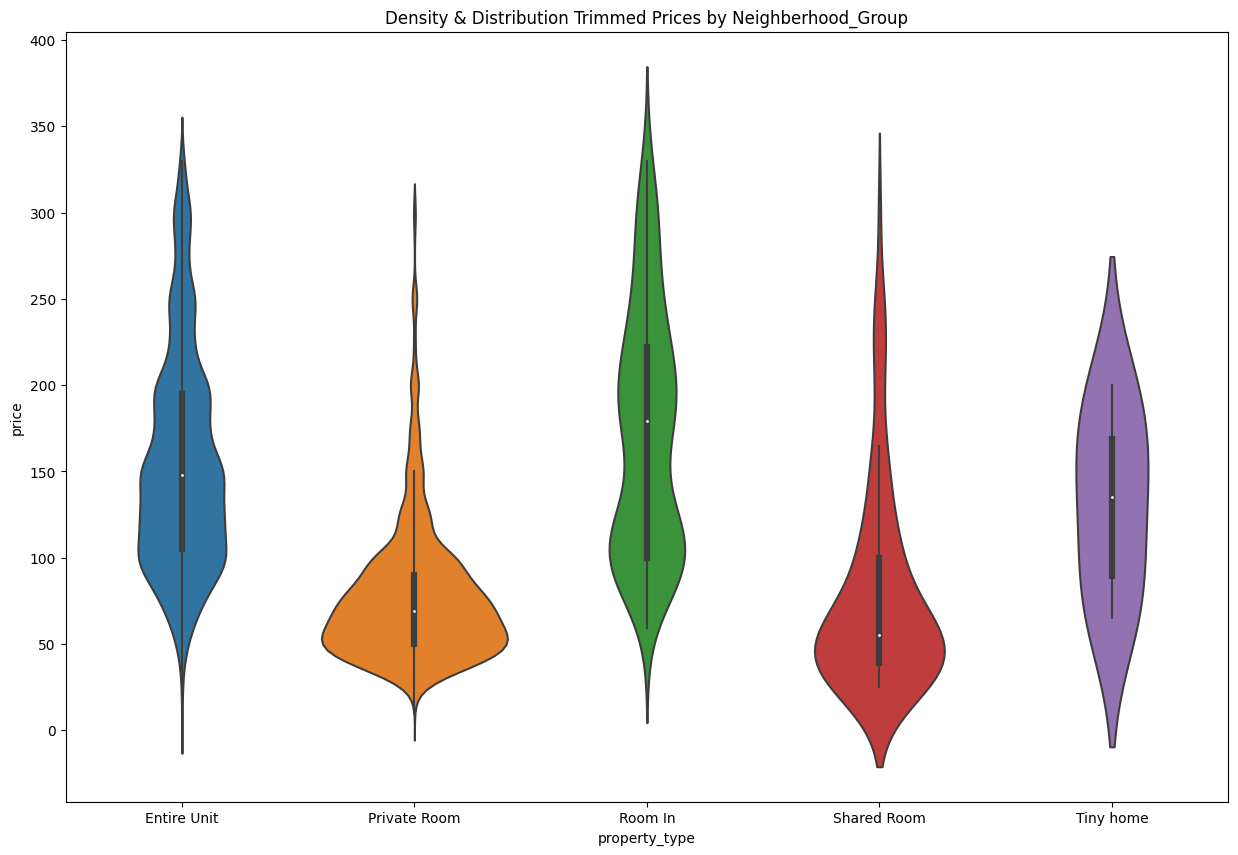

In [73]:
plt.figure(figsize=(15,10)) #size of graph
#using violinplot to showcase density and distribtuion of prices 
viz_2=sns.violinplot(palette="tab10",data=df_clean, x='property_type', y='price')
viz_2.set_title('Density & Distribution Trimmed Prices by Neighberhood_Group')

Text(0.5, 1.0, 'Density & Distribution Trimmed Prices by Neighberhood_Group')

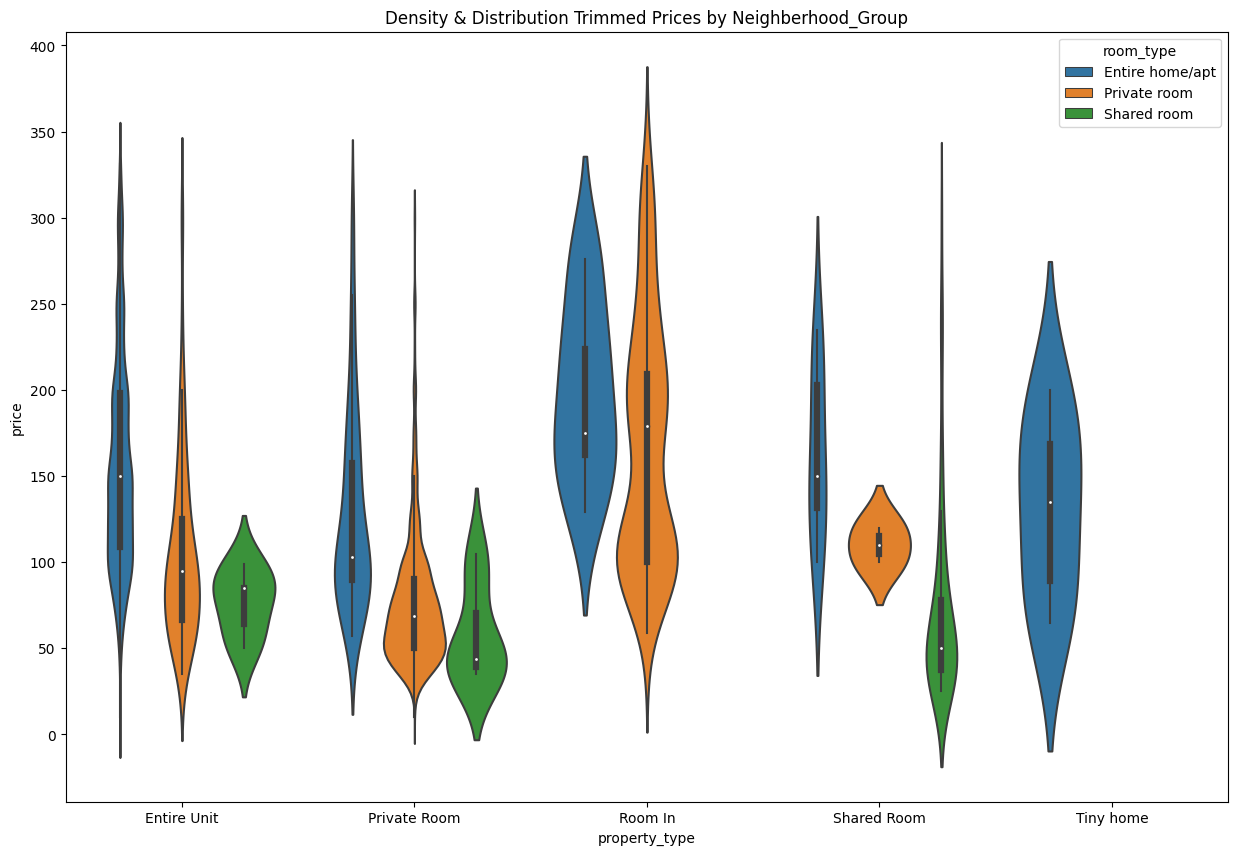

In [74]:
plt.figure(figsize=(15,10)) #size of graph
#using violinplot to showcase density and distribtuion of prices 
viz_2=sns.violinplot(palette="tab10",data=df_clean, x='property_type', y='price', hue='room_type')
viz_2.set_title('Density & Distribution Trimmed Prices by Neighberhood_Group')

Text(0.5, 1.0, 'Density & Distribution Prices by Property and Room Type')

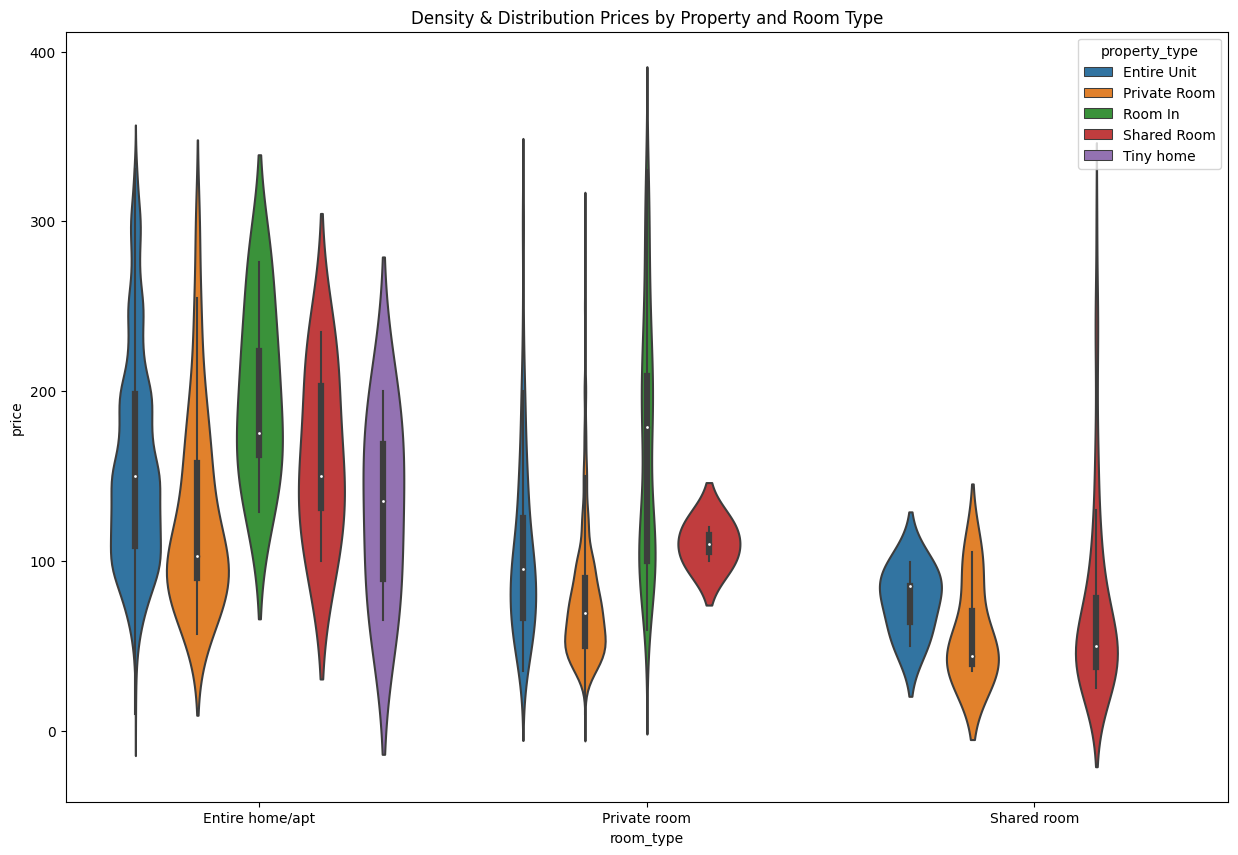

In [75]:
plt.figure(figsize=(15,10)) #size of graph



#using violinplot to showcase density and distribtuion of prices 
# all green viz_2=sns.violinplot(palette=["green"],data=df_clean, x='room_type', y='price', hue='property_type',scale_hue=True,bw='silverman')
viz_2=sns.violinplot(palette="tab10",data=df_clean, x='room_type', y='price', hue='property_type',scale_hue=True,bw='silverman')
# color palettes for violinplot = https://seaborn.pydata.org/tutorial/color_palettes.html 
viz_2.set_title('Density & Distribution Prices by Property and Room Type')


In [76]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

# **Data Visualizations**

In [77]:
from PIL import Image
import requests
from io import BytesIO

url = "https://raw.githubusercontent.com/cboyda/MachineLearning/main/New_York_City_.png"
response = requests.get(url)
#img = Image.open(BytesIO(response.content))
im = Image.open(requests.get(url, stream=True).raw)

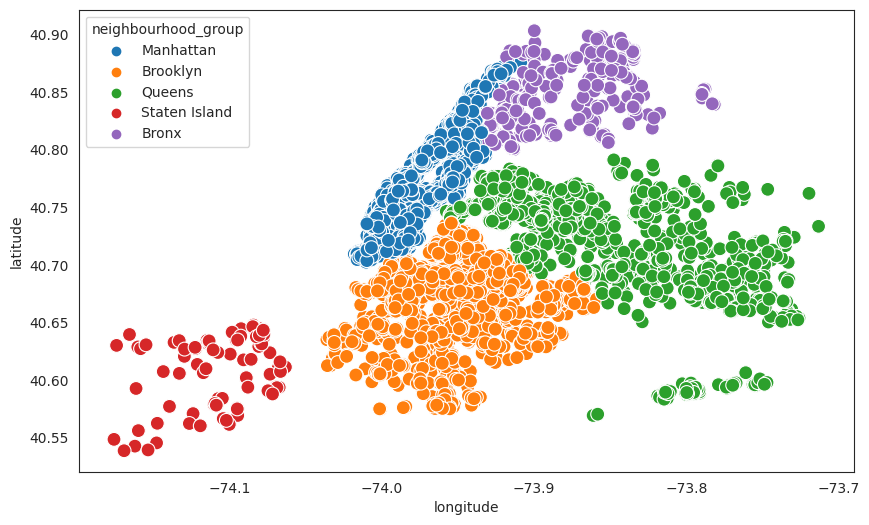

In [78]:
# display neighbourhoods
plt.figure(figsize=(10,6)) #size of graph
plt.figure.autolayout=True
sns.set_style(style='white') 
#ax.set_facecolor('white')
sns.scatterplot(palette="tab10",x=df_clean.longitude,y=df_clean.latitude,hue=df_clean.neighbourhood_group,zorder=5,s=100)
#implot = plt.imshow(im,zorder=1,aspect='auto', alpha=0.8) # WHY DOES THIS SHOW ON TOP OF MY PLOTS?????
#plt.ioff() # interactive mode off
plt.show()

In [79]:
# drop latitude and longitude after visualization needs met
df_clean.drop(['latitude','longitude'], axis=1, inplace = True)

# **Price Visualizations**

In [80]:
df_clean.columns

Index(['neighbourhood_group', 'neighbourhood', 'room_type', 'price',
       'minimum_nights', 'property_type', 'accommodates', 'bedrooms',
       'bathrooms', 'log_price'],
      dtype='object')

Text(0.5, 1.0, 'Density & Distribution Trimmed Prices by Neighberhood_Group')

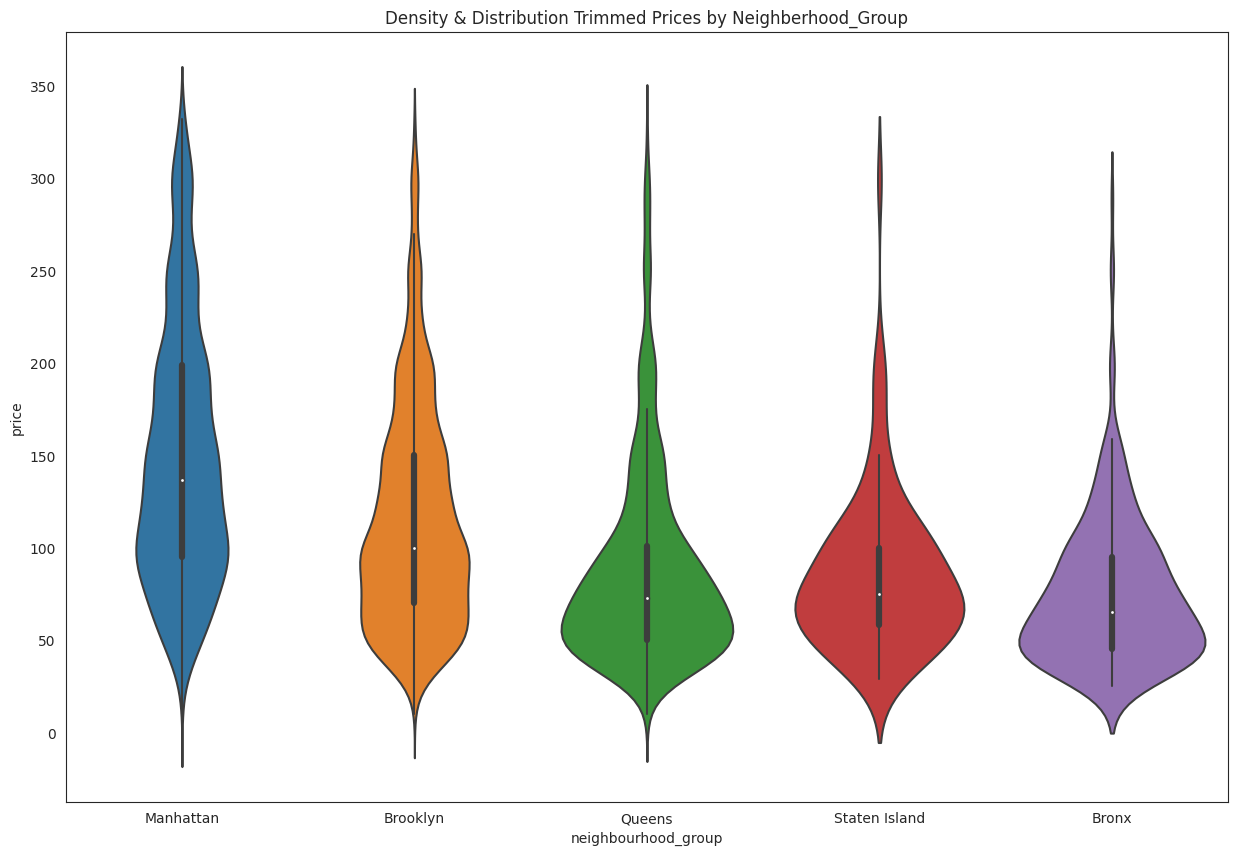

In [81]:
# need to visualize vs price before log/drop

#we can see from our statistical table that we have some extreme values, therefore we need to remove them for the sake of a better visualization

#creating a sub-dataframe with no extreme values / less than 500
#sub_6=df_clean[df_clean.price < 500]
sub_6=df_clean
plt.figure(figsize=(15,10)) #size of graph
#using violinplot to showcase density and distribtuion of prices 
viz_2=sns.violinplot(palette="tab10",data=sub_6, x='neighbourhood_group', y='price')
viz_2.set_title('Density & Distribution Trimmed Prices by Neighberhood_Group')

In [82]:
sub_6


neighbourhood_group    neighbourhood        room_type  price  \
0               Manhattan          Midtown  Entire home/apt    225   
2               Manhattan   Hell's Kitchen     Private room     79   
4                Brooklyn      South Slope     Private room     89   
5                Brooklyn     Williamsburg  Entire home/apt    140   
6                Brooklyn      Fort Greene  Entire home/apt    215   
...                   ...              ...              ...    ...   
16000              Queens        Woodhaven  Entire home/apt     85   
16001           Manhattan  Upper East Side     Private room     95   
16002            Brooklyn        Flatlands  Entire home/apt    170   
16003            Brooklyn       Greenpoint     Private room     54   
16004           Manhattan   Hell's Kitchen     Private room     90   

       minimum_nights property_type  accommodates  bedrooms  bathrooms  \
0                   1   Entire Unit             1       0.0        1.0   
2                   2  Private Room             2       1.0        1.0   
4                   4  Private Room             2       1.0        1.5   
5                   2   Entire Unit             3       0.0        1.0   
6                   2   Entire Unit             4       1.0        1.0   
...               ...           ...           ...       ...        ...   
16000               3   Entire Unit             2       1.0        1.0   
16001               1  Private Room             2       1.0        1.0   
16002               1   Entire Unit             6       2.0        1.0   
16003               6  Private Room             2       1.0        1.0   
16004               7  Private Room             2       1.0        2.0   

       log_price  
0       5.416100  
2       4.369448  
4       4.488636  
5       4.941642  
6       5.370638  
...          ...  
16000   4.442651  
16001   4.553877  
16002   5.135798  
16003   3.988984  
16004   4.499810  

[7873 rows x 10 columns]

Text(0.5, 1.0, 'Density & Distribution Original Prices by Neighberhood_Group')

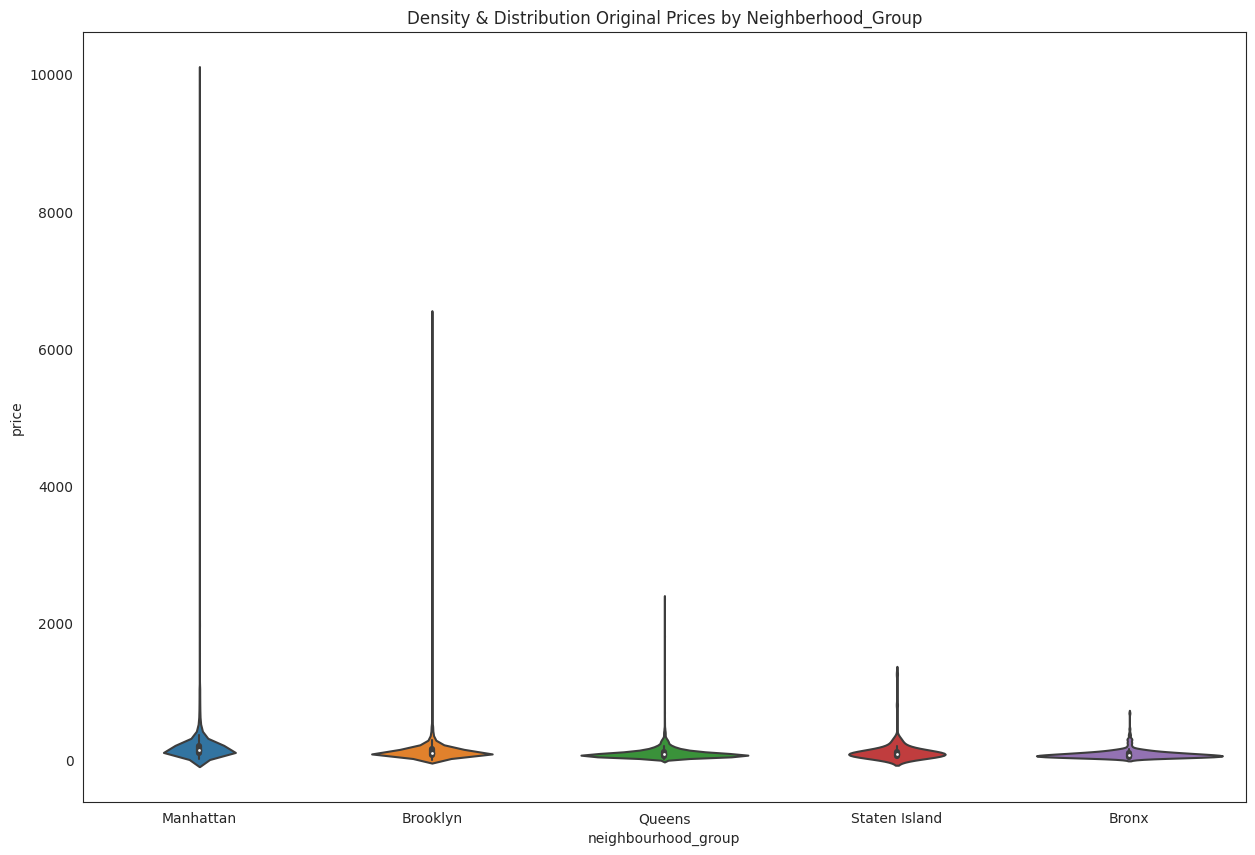

In [83]:
sub_6=df # vs uncleaned data
plt.figure(figsize=(15,10)) #size of graph width/height)
#using violinplot to showcase density and distribtuion of prices 
viz_2=sns.violinplot(palette="tab10",data=sub_6, x='neighbourhood_group', y='price')
viz_2.set_title('Density & Distribution Original Prices by Neighberhood_Group')

Text(0.5, 1.0, 'Density & Distribution Trimmed Prices by Property Type')

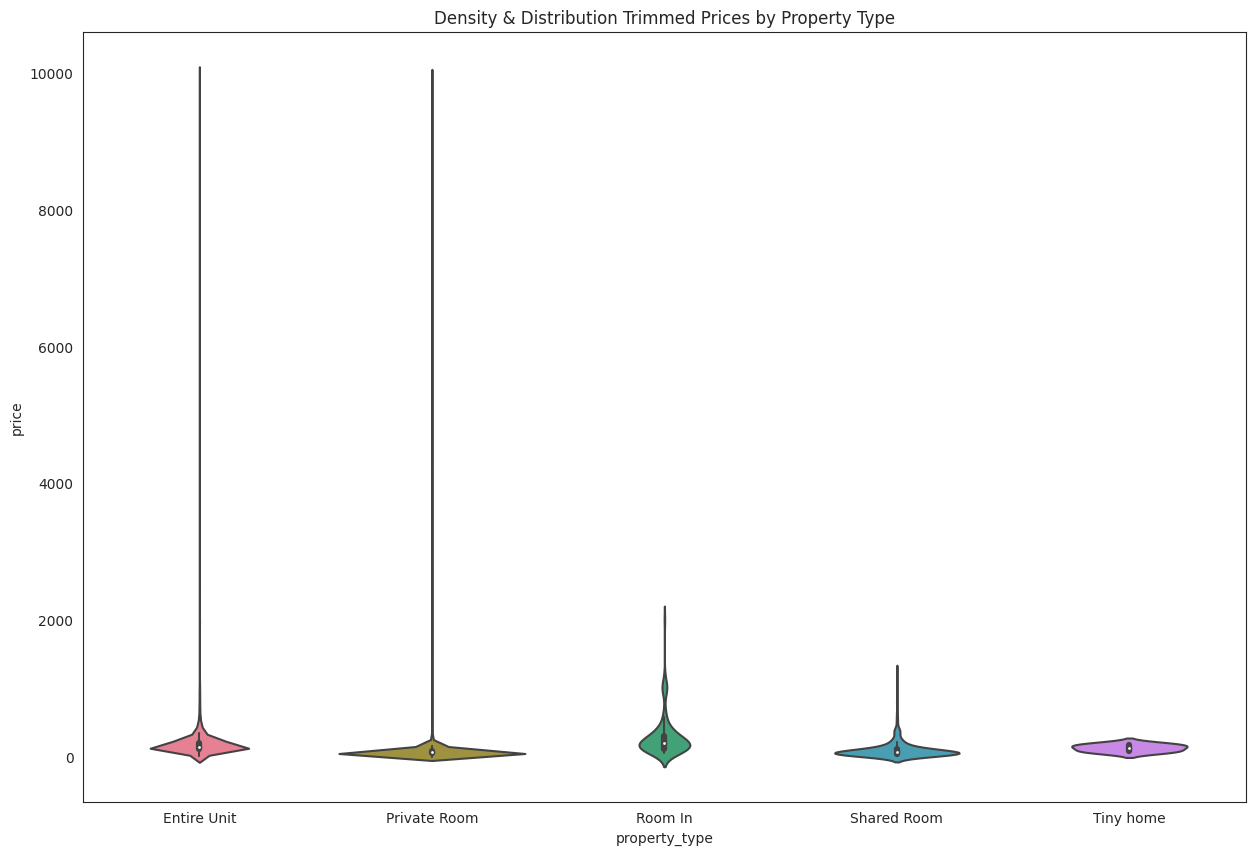

In [84]:
# BEFORE cleaning
sub_6=df # vs cleaned data
plt.figure(figsize=(15,10)) #size of graph width/height)
#using violinplot to showcase density and distribtuion of prices 
viz_2=sns.violinplot(palette="husl",data=sub_6, x='property_type', y='price')
viz_2.set_title('Density & Distribution Trimmed Prices by Property Type')

Text(0.5, 1.0, 'Density & Distribution Trimmed Prices by Property Type')

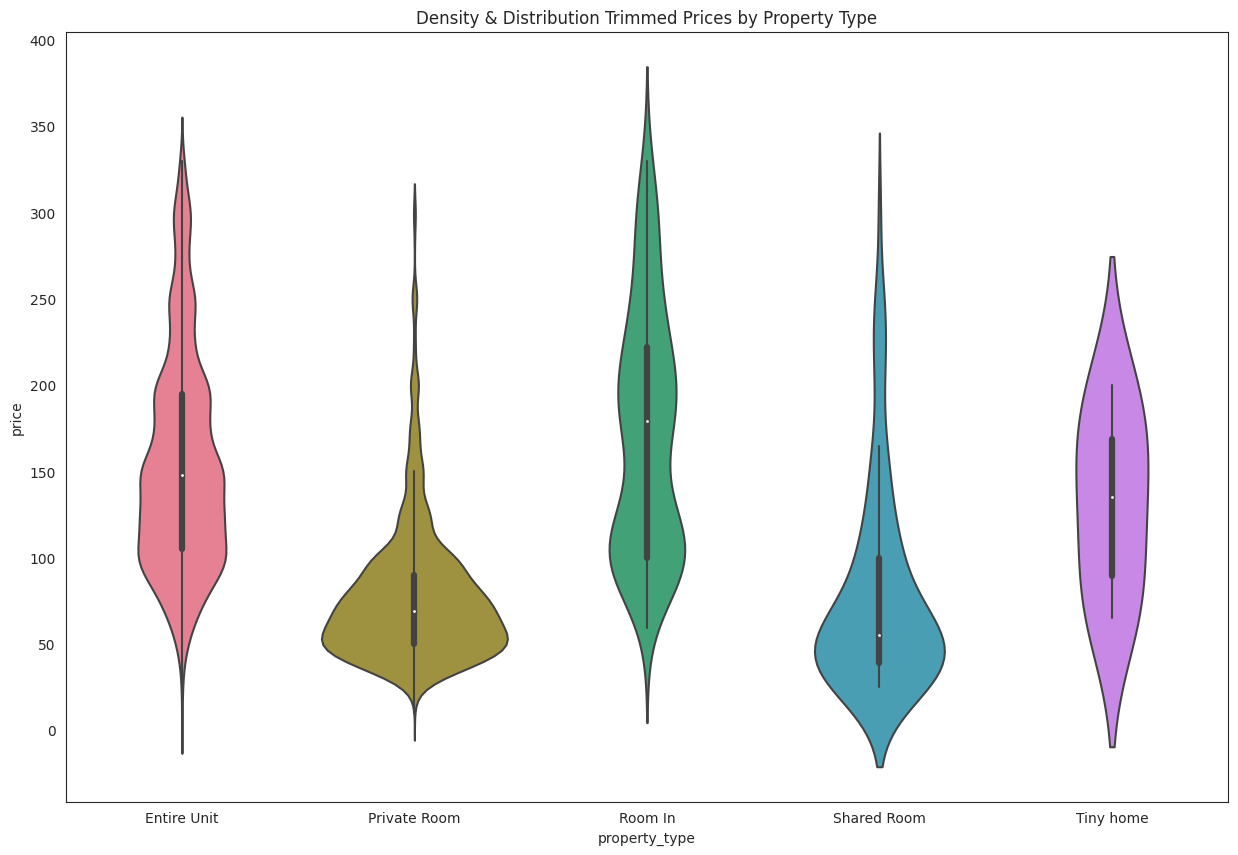

In [85]:
# AFTER cleaning room_type
sub_6=df_clean # vs cleaned data
plt.figure(figsize=(15,10)) #size of graph width/height)
#using violinplot to showcase density and distribtuion of prices 
viz_2=sns.violinplot(palette="husl",data=sub_6, x='property_type', y='price')
viz_2.set_title('Density & Distribution Trimmed Prices by Property Type')

In [86]:
df_clean.dtypes

neighbourhood_group     object
neighbourhood           object
room_type               object
price                    int64
minimum_nights           int64
property_type           object
accommodates             int64
bedrooms               float64
bathrooms              float64
log_price              float64
dtype: object

# **Drop Cleaned but Unnecessary Columns/Features**

In [87]:
# dropping price as preference to keep ONLY log_price
df_clean.drop('price', axis= 1, inplace=True)

In [88]:
# after FILTERING rows with zero minimum nights, we don't need minimium nights any longer, just drop that entire feature
df_clean.drop(['minimum_nights'], axis=1, inplace = True)

In [89]:
df_clean.columns

Index(['neighbourhood_group', 'neighbourhood', 'room_type', 'property_type',
       'accommodates', 'bedrooms', 'bathrooms', 'log_price'],
      dtype='object')

# **Declaration, Normalization and Scaling of Data**

In [90]:
df_clean.head(5)

neighbourhood_group   neighbourhood        room_type property_type  \
0           Manhattan         Midtown  Entire home/apt   Entire Unit   
2           Manhattan  Hell's Kitchen     Private room  Private Room   
4            Brooklyn     South Slope     Private room  Private Room   
5            Brooklyn    Williamsburg  Entire home/apt   Entire Unit   
6            Brooklyn     Fort Greene  Entire home/apt   Entire Unit   

   accommodates  bedrooms  bathrooms  log_price  
0             1       0.0        1.0   5.416100  
2             2       1.0        1.0   4.369448  
4             2       1.0        1.5   4.488636  
5             3       0.0        1.0   4.941642  
6             4       1.0        1.0   5.370638

In [91]:
df_clean.columns

Index(['neighbourhood_group', 'neighbourhood', 'room_type', 'property_type',
       'accommodates', 'bedrooms', 'bathrooms', 'log_price'],
      dtype='object')

In [92]:
column_names= df_clean.columns
features = column_names[column_names != 'log_price']
label = column_names[-1]
display(features, label)


Index(['neighbourhood_group', 'neighbourhood', 'room_type', 'property_type',
       'accommodates', 'bedrooms', 'bathrooms'],
      dtype='object')

'log_price'

In [93]:
Example_Count = len(df_clean)
Feature_Count = len(df_clean.columns) - 1

print("Number of Examples:", Example_Count)
print("Number Features:", Feature_Count)

Number of Examples: 7873
Number Features: 7


In [94]:
numerical_features = np.array(df_clean.select_dtypes(include=['int64','float64','uint8']).columns)

non_numerical_features = np.array([column for column in df_clean.columns \
                                   if column not in numerical_features and \
                                      column != label])

In [95]:
# need to ensure your LABEL is not a column listed in the FEATURES else columntransformer fails
#numerical_features = numerical_features[:-1]
numerical_features = numerical_features[numerical_features != 'log_price']
numerical_features

array(['accommodates', 'bedrooms', 'bathrooms'], dtype=object)

In [96]:
# could have been called categorical_features
non_numerical_features 

array(['neighbourhood_group', 'neighbourhood', 'room_type',
       'property_type'], dtype='<U19')

# **Numerical Analysis**

Now that we have ALL numeric features we can analyze them using correlation etc...

<Axes: title={'center': 'Correlation with Independent Variable'}>

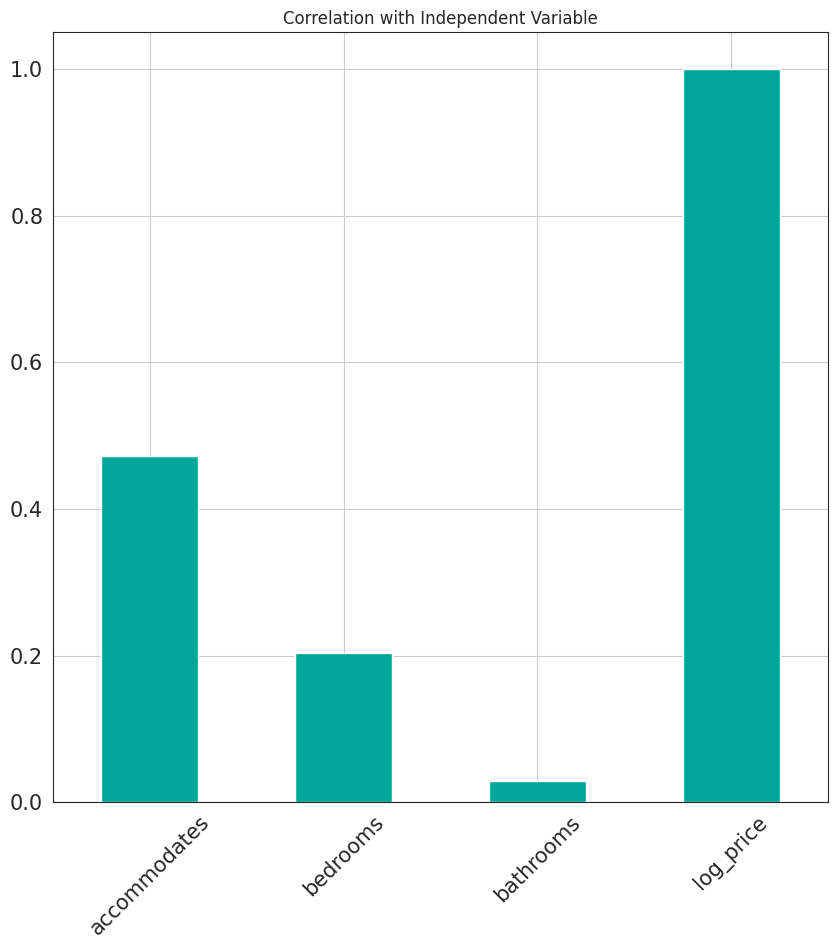

In [97]:
# Correlation with independent Variable (Note: Models like RF are not linear like these)
df_clean.corrwith(df_clean[label]).plot.bar(
        figsize = (10, 10), title = "Correlation with Independent Variable", fontsize = 15,
        rot = 45, grid = True, color='#00A699')

In [98]:
df_clean.describe()

accommodates     bedrooms    bathrooms    log_price
count   7873.000000  7873.000000  7873.000000  7873.000000
mean       2.649816     1.130827     1.091261     4.650478
std        1.375764     0.648369     0.306638     0.557416
min        1.000000     0.000000     0.000000     2.302585
25%        2.000000     1.000000     1.000000     4.248495
50%        2.000000     1.000000     1.000000     4.615121
75%        4.000000     1.000000     1.000000     5.068904
max        7.000000     8.000000     4.000000     5.805135

In [99]:
#Show all correlation values
df_corr = df_clean.corr().round(1)  
# Mask to matrix
mask = np.zeros_like(df_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# Viz
df_corr_viz = df_corr.mask(mask).dropna(how='all').dropna(how='all')
# colour variable https://plotly.com/python/colorscales/
fig = px.imshow(df_corr_viz, text_auto=True, color_continuous_scale=[(0.00, '#FF5A5F'),   (0.33, "black"),
                                                     (0.33, "white"), (0.66, 'white'),
                                                     (0.66, "blue"),  (1.00, '#00A699')])
fig.show()

# **Pre-processing for ML Models**

In [100]:
df_clean.shape

(7873, 8)

In [101]:
#Define X and y
#X = df_clean.loc[:,california['feature_names']]
#y = df_clean.loc[:,'MEDV']

#X = df[numerical_features+non_numerical_features]
#y = df['target']
X = df_clean[features]
y = df_clean[label]
display ("Types of X and y need to be DF and Series", type(X),type(y))

'Types of X and y need to be DF and Series'

pandas.core.frame.DataFrame

pandas.core.series.Series

In [102]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder

# numeric_features = accomodates/bedrooms/bathrooms
numeric_transformer = Pipeline(
    steps=[("scaler", MinMaxScaler())] # returns higher accuracy
    #steps=[("scaler", StandardScaler())]
)

# categorical_features = neighbourhood_group/room_type/property_type
categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown='ignore'))])


preprocessor = ColumnTransformer(
    transformers=[
        ("numeric features", numeric_transformer, numerical_features)
        ,("categorical features", categorical_transformer, non_numerical_features)
    ],
    n_jobs=-1
)

NOTE: OneHotEncoder now requires handle_unknown parameter because testing dataset is so small it doesn't include every possible variable(s) example.  This is demonstrated in the unique values of X_train vs X_test.

In [103]:
#Splitting the Dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((6298, 7), (1575, 7), (6298,), (1575,))

In [104]:
X_train.nunique(axis=0)

neighbourhood_group      5
neighbourhood          195
room_type                3
property_type            5
accommodates             7
bedrooms                 7
bathrooms                7
dtype: int64

In [105]:
X_test.nunique(axis=0)

neighbourhood_group      5
neighbourhood          156
room_type                3
property_type            5
accommodates             7
bedrooms                 6
bathrooms                6
dtype: int64

# **Call Pipeline of Regression Models**

In [106]:
numerical_features

array(['accommodates', 'bedrooms', 'bathrooms'], dtype=object)

In [107]:
non_numerical_features

array(['neighbourhood_group', 'neighbourhood', 'room_type',
       'property_type'], dtype='<U19')

In [108]:
df_clean.columns

Index(['neighbourhood_group', 'neighbourhood', 'room_type', 'property_type',
       'accommodates', 'bedrooms', 'bathrooms', 'log_price'],
      dtype='object')

In [109]:
df_clean["log_price"]

0        5.416100
2        4.369448
4        4.488636
5        4.941642
6        5.370638
           ...   
16000    4.442651
16001    4.553877
16002    5.135798
16003    3.988984
16004    4.499810
Name: log_price, Length: 7873, dtype: float64

# Create bias variance function

In [110]:
from sklearn.utils import resample
def estimate_model_bias_variance(pipeline,regressor,preprocessor, X_train, y_train, X_test, y_test, \
                                 num_trials, resample_size):

  yhat_test_trial = np.tile(y_test[:, None], (1, num_trials))

  for i in range(num_trials):
    X_train_trial, y_train_trial = \
      resample(X_train, y_train, replace=False, n_samples=resample_size)
    #estimator.fit(X_train_trial, y_train_trial)
    model = pipeline.fit(X_train, y_train)
    yhat_test_trial[:, i] = model.predict(X_test)

  prediction_variances = yhat_test_trial.std(axis=1)
  model_variance_estimate = prediction_variances.mean()
  model_variance_std = prediction_variances.std()
  prediction_mae = np.abs(yhat_test_trial - y_test[:, None]).mean(axis=1)
  model_bias_estimate = prediction_mae.mean()
  model_bias_std = prediction_mae.std()

  return (model_bias_estimate, model_variance_estimate, \
          model_bias_std, model_variance_std)

In [111]:
#pd.set_option('display.expand_frame_repr', False)

In [112]:
pd.set_option('display.max_colwidth', 80)

In [113]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics

#define results dataframe to store results
results = pd.DataFrame([],
               columns = ['Model_Name', 'MAE', 'MSE', 'RMSE', 'R2 Score', 'parameters'])

score_results = pd.DataFrame([],
               columns = ['Model_Name', 'y_train', 'y_test'])

regressors = [
    KNeighborsRegressor(weights='uniform')
   ,KNeighborsRegressor(weights='distance')
   ,DecisionTreeRegressor(random_state=0)
   ,RandomForestRegressor(random_state=0)
   ,SVR()
   ,AdaBoostRegressor()
   ,GradientBoostingRegressor()
   ,LinearRegression()
   ]

## create empty list to save bias and variance for all model
Bias_Variance = [[] for i in range(len(regressors))]
count = 0
for regressor in regressors:
    pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor',regressor)
           ])
    model = pipeline.fit(X_train, y_train)
    
    model_name = str(regressor)
    # Predicting/Measuring Test Set
    y_pred = model.predict(X_test)

    num_trials = 5  
    m_train, n = X_train.shape
    resample_size = m_train // 2

    bias, variance, bstd, sstd = estimate_model_bias_variance(pipeline,regressor,preprocessor, X_train, y_train, \
                                              X_test, y_test, \
                                              num_trials, resample_size)
    Bias_Variance[count] = [model_name,bias, variance, bstd, sstd]
    
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    r2 = metrics.r2_score(y_test, y_pred)
    model_results = pd.DataFrame([[model_name, mae, mse, rmse, r2, regressor]],
    #model_results = pd.DataFrame([[model_name, '{:.3}%'.format(mae*100), '{:.3}%'.format(mse*100), '{:.3}%'.format(rmse*100), '{:.3}%'.format(r2*100)]],
                  columns = ['Model_Name', 'MAE', 'MSE', 'RMSE', 'R2 Score','parameters'])
    results = results.append(model_results, ignore_index = True)
    
    #print (model_name, "found R2 from training as", '{:.3}%'.format(model.score(X_train,y_train)*100), "vs testing of", '{:.3}%'.format(model.score(X_test,y_test)*100))
    compare_results = pd.DataFrame([[model_name, '{:.3}%'.format(model.score(X_train,y_train)*100), '{:.3}%'.format(model.score(X_test,y_test)*100)]],
                  columns = ['Model_Name', 'y_train', 'y_test'])
    score_results = score_results.append(compare_results, ignore_index = True)

    count += 1

# sort results by R2 score and select best model
best_model = results.sort_values('R2 Score', ascending=False).iloc[0]
print('Best Model:')
print(best_model)

# extract best model parameters
best_model_params = best_model['parameters']

Best Model:
Model_Name       SVR()
MAE           0.254196
MSE           0.111305
RMSE          0.333624
R2 Score      0.635202
parameters       SVR()
Name: 4, dtype: object


In [114]:
best_model

Model_Name       SVR()
MAE           0.254196
MSE           0.111305
RMSE          0.333624
R2 Score      0.635202
parameters       SVR()
Name: 4, dtype: object

In [115]:
"""
# not needed for capstone
Bias_Variance
Bias_Variance_dataframe = pd.DataFrame(Bias_Variance, columns=["Model Name", "model_bias_estimate", "model_variance_estimate", "model_bias_std", "model_variance_std"])
Bias_Variance_dataframe

plt.errorbar(Bias_Variance_dataframe['Model Name'], Bias_Variance_dataframe['model_bias_estimate'], Bias_Variance_dataframe['model_bias_std'], linestyle='None', marker='^', label = 'Bias')
plt.errorbar(Bias_Variance_dataframe['Model Name'], Bias_Variance_dataframe['model_variance_estimate'], Bias_Variance_dataframe['model_variance_std'], linestyle='None', marker='o',label= 'Variance')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Models')
plt.ylabel('model_error_estimate')
plt.legend()
plt.show()
"""

'\n# not needed for capstone\nBias_Variance\nBias_Variance_dataframe = pd.DataFrame(Bias_Variance, columns=["Model Name", "model_bias_estimate", "model_variance_estimate", "model_bias_std", "model_variance_std"])\nBias_Variance_dataframe\n\nplt.errorbar(Bias_Variance_dataframe[\'Model Name\'], Bias_Variance_dataframe[\'model_bias_estimate\'], Bias_Variance_dataframe[\'model_bias_std\'], linestyle=\'None\', marker=\'^\', label = \'Bias\')\nplt.errorbar(Bias_Variance_dataframe[\'Model Name\'], Bias_Variance_dataframe[\'model_variance_estimate\'], Bias_Variance_dataframe[\'model_variance_std\'], linestyle=\'None\', marker=\'o\',label= \'Variance\')\nplt.xticks(rotation=45, ha=\'right\')\nplt.xlabel(\'Models\')\nplt.ylabel(\'model_error_estimate\')\nplt.legend()\nplt.show()\n'

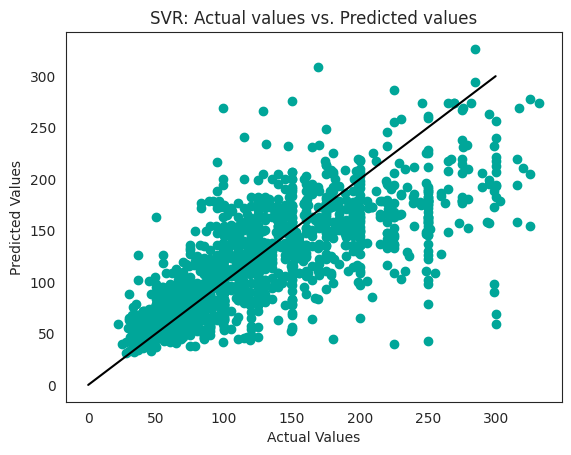

In [116]:
# create new pipeline with best model parameters
best_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', best_model_params)
])

# fit best model on full training set
best_model_fit = best_pipeline.fit(X_train, y_train)

# Predict on test set and create plot of predicted vs. actual values
y_pred = best_model_fit.predict(X_test)

plt.scatter(np.exp(y_test), np.exp(y_pred), color='#00A699')
plt.plot([0, 300], [0, 300], 'k-')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('SVR: Actual values vs. Predicted values')
plt.show()


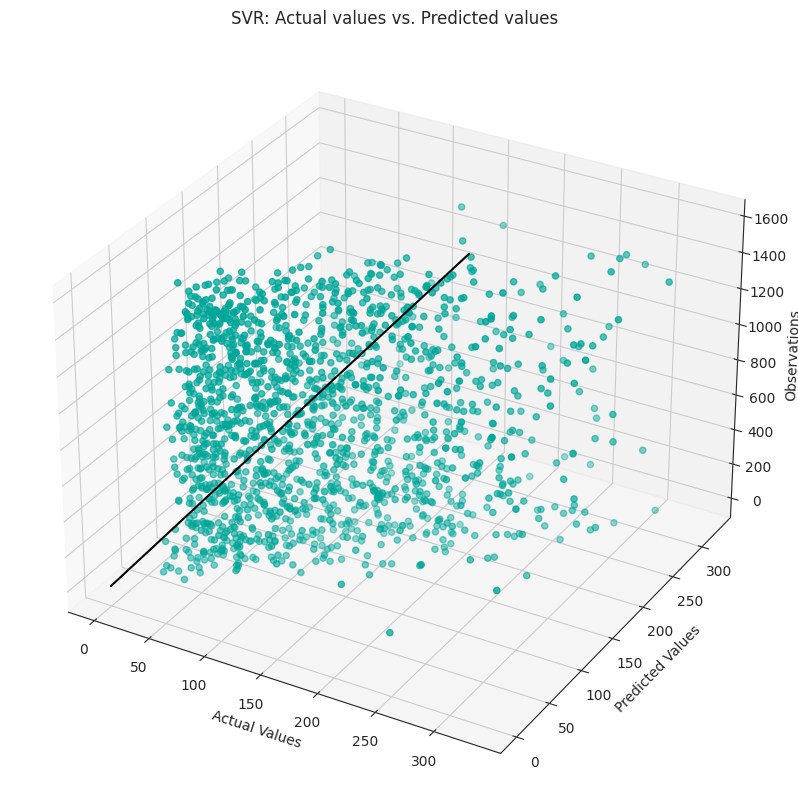

In [117]:
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(np.exp(y_test), np.exp(y_pred), range(len(y_pred)), color='#00A699')
ax.plot([0, 200], [0, 200], [0, len(y_pred)], 'k-')
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
ax.set_zlabel('Observations')
ax.set_title('SVR: Actual values vs. Predicted values')
plt.show()

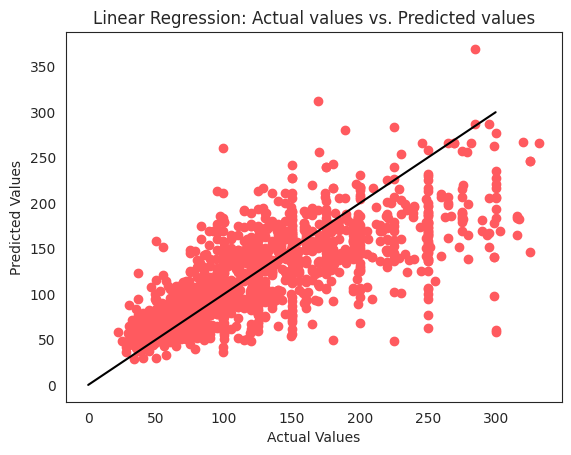

In [118]:
# create new pipeline with best model parameters
best_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# fit best model on full training set
lr_model_fit = best_pipeline.fit(X_train, y_train)

# Predict on test set and create plot of predicted vs. actual values
y_pred_lr = lr_model_fit.predict(X_test)

plt.scatter(np.exp(y_test), np.exp(y_pred_lr),color='#FF5A5F')
plt.plot([0, 300], [0, 300], 'k-')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression: Actual values vs. Predicted values')
plt.show()

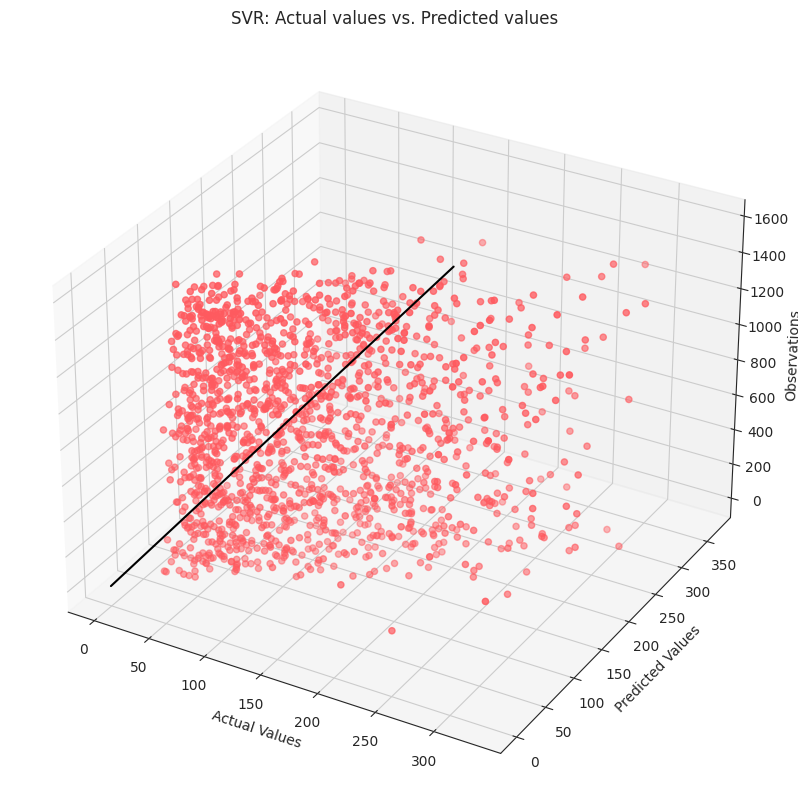

In [119]:
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(np.exp(y_test), np.exp(y_pred_lr), range(len(y_pred_lr)), color='#FF5A5F')
ax.plot([0, 200], [0, 200], [0, len(y_pred_lr)], 'k-')
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
ax.set_zlabel('Observations')
ax.set_title('SVR: Actual values vs. Predicted values')
plt.show()

In [120]:
display (score_results.sort_values(by='y_test', ascending=False)) # display nicer df output than print

Model_Name y_train y_test
4                                    SVR()   68.1%  63.5%
7                       LinearRegression()   64.3%  63.1%
6              GradientBoostingRegressor()   63.4%  61.9%
3    RandomForestRegressor(random_state=0)   76.9%  61.3%
2    DecisionTreeRegressor(random_state=0)   78.2%  56.0%
0                    KNeighborsRegressor()   65.9%  55.1%
1  KNeighborsRegressor(weights='distance')   74.7%  54.2%
5                      AdaBoostRegressor()   47.8%  46.9%

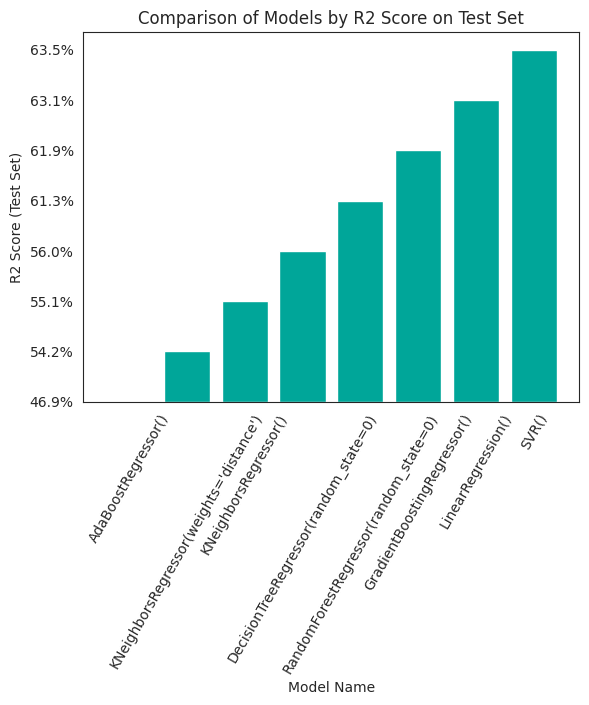

In [121]:
sorted_results = score_results.sort_values(by='y_test', ascending=True)

plt.bar(sorted_results['Model_Name'], sorted_results['y_test'], color='#00A699')
plt.xticks(rotation=60)
plt.xlabel('Model Name')
plt.ylabel('R2 Score (Test Set)')
plt.title('Comparison of Models by R2 Score on Test Set')
plt.show()

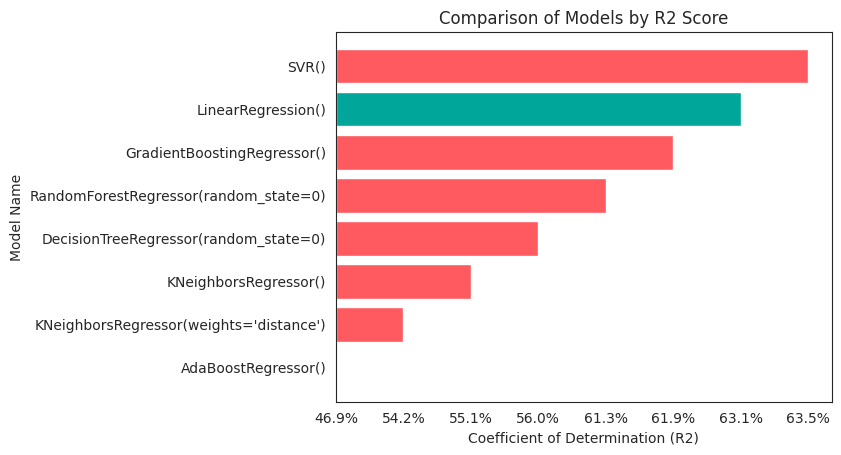

In [122]:
# horizontal bar chart for slide show
plt.barh(sorted_results['Model_Name'], sorted_results['y_test'], color=['#ff5a5fff']*6 + ['#00A699'])
plt.ylabel('Model Name')
plt.xlabel('Coefficient of Determination (R2)')
plt.title('Comparison of Models by R2 Score')
plt.show()

In [123]:
#The best model
print ("Merged dataset results:")
display (results.sort_values(by='R2 Score', ascending=False)) # display nicer df output than print
# regression accuracy = R2

Merged dataset results:


Model_Name       MAE       MSE      RMSE  \
4                                    SVR()  0.254196  0.111305  0.333624   
7                       LinearRegression()  0.258880  0.112491  0.335397   
6              GradientBoostingRegressor()  0.267671  0.116191  0.340867   
3    RandomForestRegressor(random_state=0)  0.260945  0.118088  0.343639   
2    DecisionTreeRegressor(random_state=0)  0.274347  0.134163  0.366283   
0                    KNeighborsRegressor()  0.282286  0.137016  0.370157   
1  KNeighborsRegressor(weights='distance')  0.282790  0.139596  0.373625   
5                      AdaBoostRegressor()  0.317718  0.158827  0.398531   

   R2 Score  \
4  0.635202   
7  0.631314   
6  0.619189   
3  0.612971   
2  0.560284   
0  0.550934   
1  0.542479   
5  0.479449   

                                                                        parameters  
4                                                                            SVR()  
7                                                               LinearRegression()  
6  ([DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n            ...  
3  (DecisionTreeRegressor(max_features=1.0, random_state=209652396), DecisionTr...  
2                                            DecisionTreeRegressor(random_state=0)  
0                                                            KNeighborsRegressor()  
1                                          KNeighborsRegressor(weights='distance')  
5  (DecisionTreeRegressor(max_depth=3, random_state=1203509489), DecisionTreeRe...

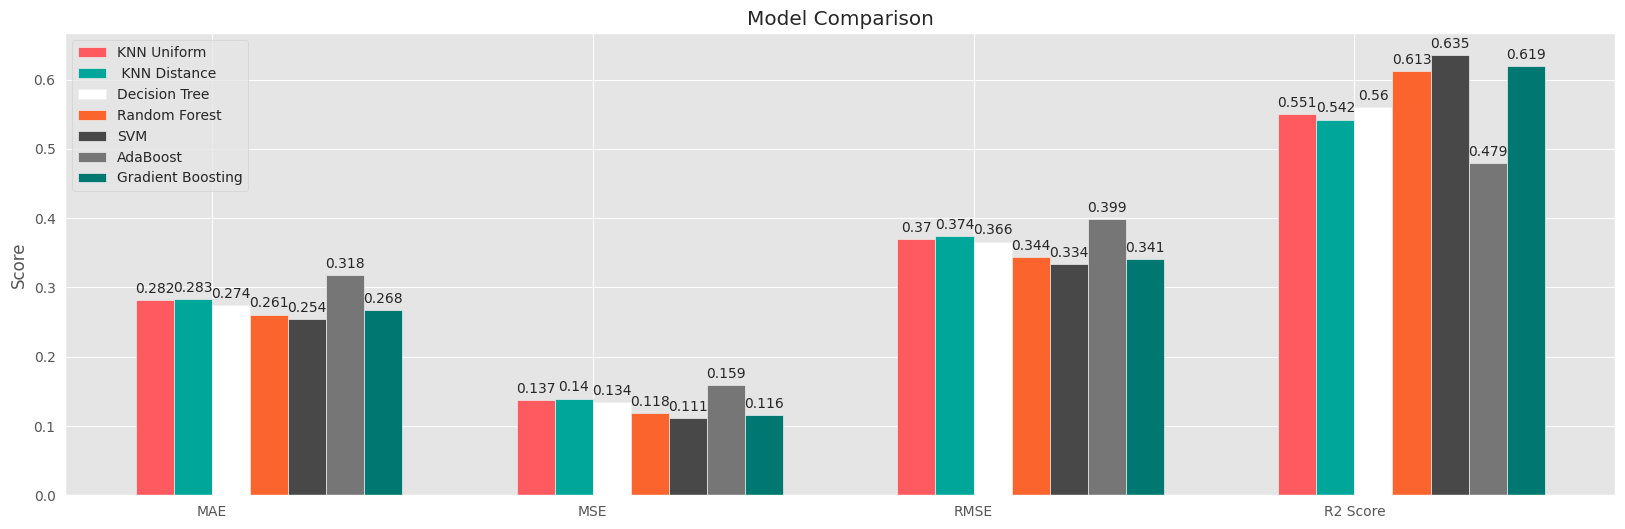

In [124]:
# Set the style of the plot
plt.style.use('ggplot')

# Define the x-axis labels
labels = ['MAE', 'MSE', 'RMSE', 'R2 Score']

# Define the values for each model and metric
knn_uniform = results.loc[0, ['MAE', 'MSE', 'RMSE', 'R2 Score']].values
knn_distance = results.loc[1, ['MAE', 'MSE', 'RMSE', 'R2 Score']].values
dt = results.loc[2, ['MAE', 'MSE', 'RMSE', 'R2 Score']].values
rf = results.loc[3, ['MAE', 'MSE', 'RMSE', 'R2 Score']].values
svm = results.loc[4, ['MAE', 'MSE', 'RMSE', 'R2 Score']].values
adaboost = results.loc[5, ['MAE', 'MSE', 'RMSE', 'R2 Score']].values
gb = results.loc[6, ['MAE', 'MSE', 'RMSE', 'R2 Score']].values

# Define the x- and y-axis values
x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars
fig, ax = plt.subplots(figsize=(20,6))

# Define the colors for each bar
colors = ['#FF5A5F', '#00A699', '#FFFFFF', '#FC642D', '#484848', '#767676', '#007872']

rects1 = ax.bar(x - 3*width/2, knn_uniform, width, label='KNN Uniform', color=colors[0])
rects2 = ax.bar(x - width/2, knn_distance, width, label=' KNN Distance', color=colors[1])
rects3 = ax.bar(x + width/2, dt, width, label='Decision Tree', color=colors[2])
rects4 = ax.bar(x + 3*width/2, rf, width, label='Random Forest', color=colors[3])
rects5 = ax.bar(x + 5*width/2, svm, width, label='SVM', color=colors[4])
rects6 = ax.bar(x + 7*width/2, adaboost, width, label='AdaBoost', color=colors[5])
rects7 = ax.bar(x + 9*width/2, gb, width, label='Gradient Boosting', color=colors[6])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add the value labels on the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
                    
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)
autolabel(rects6)
autolabel(rects7)

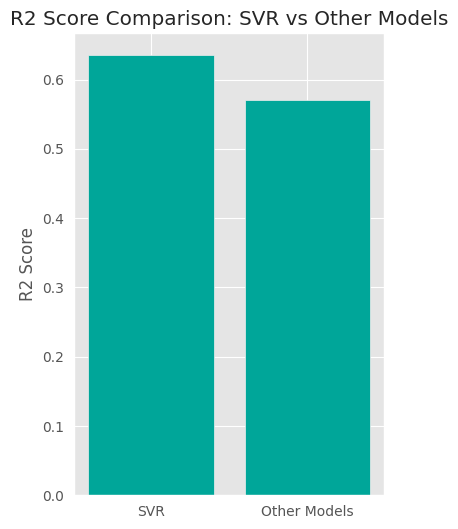

In [125]:
# Filter results dataframe to only include SVR model
svr_results = results[results['Model_Name'].astype(str).str.contains('SVR')]

# Get R2 scores for SVR model
svr_r2_scores = svr_results['R2 Score'].values

# Get R2 scores for other models
other_r2_scores = results[~results['Model_Name'].astype(str).str.contains('SVR')]['R2 Score'].values

# Create plot
fig, ax = plt.subplots(figsize=(4,6))
ax.bar(['SVR', 'Other Models'], [svr_r2_scores.mean(), other_r2_scores.mean()],color='#00A699')
ax.set_title('R2 Score Comparison: SVR vs Other Models')
ax.set_ylabel('R2 Score')
plt.show()

In [126]:
from sklearn.compose import ColumnTransformer
transformer = ColumnTransformer(transformers=[
    ('tnf1', OneHotEncoder(sparse= False, drop = 'first'),['neighbourhood_group','room_type','property_type']),
    ('tnf2',MinMaxScaler(),['accommodates', 'bedrooms','bathrooms'])
])

In [127]:
X_train_transformed = transformer.fit_transform(X_train)   
X_test_transformed = transformer.transform(X_test)

In [128]:
X_train_transformed.shape


(6298, 13)

In [129]:
from sklearn.utils import resample
def estimate_model_bias_variance(estimator, X_train, y_train, X_test, y_test, \
                                 num_trials, resample_size):

  yhat_test_trial = np.tile(y_test[:, None], (1, num_trials))

  for i in range(num_trials):
    X_train_trial, y_train_trial = \
      resample(X_train, y_train, replace=False, n_samples=resample_size)
    estimator.fit(X_train_trial, y_train_trial)
    yhat_test_trial[:, i] = estimator.predict(X_test)

  prediction_variances = yhat_test_trial.std(axis=1)
  model_variance_estimate = prediction_variances.mean()
  model_variance_std = prediction_variances.std()
  prediction_mae = np.abs(yhat_test_trial - y_test[:, None]).mean(axis=1)
  model_bias_estimate = prediction_mae.mean()
  model_bias_std = prediction_mae.std()

  return (model_bias_estimate, model_variance_estimate, \
          model_bias_std, model_variance_std)

In [130]:
from sklearn.ensemble import RandomForestRegressor
num_trials = 100
m_train, n = X_train_transformed.shape

resample_size = m_train // 2

rforest_regressor = RandomForestRegressor()
bias, variance, bstd, sstd = estimate_model_bias_variance(rforest_regressor, X_train_transformed, y_train, \
                                              X_test_transformed, y_test, \
                                              num_trials, resample_size)

In [131]:
print("bias:", bias, "+/-", bstd)
print("variance:", variance, "+/-", sstd)

bias: 0.29461561023057664 +/- 0.22493678874983072
variance: 0.05266246251636646 +/- 0.05231367633837273


# Grid Search to find best parameters for top 3 models


In [132]:
#Import grid search function
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

##1. SVR


In [133]:
#Define the SVR model
from sklearn.svm import SVR
SVR = SVR()

In [134]:
#Define the hyperparameters to tune
parameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
              'gamma': ['scale', 'auto']}


In [135]:
#Create a GridSearchCV Object
grid_SVR = GridSearchCV(SVR, parameters, cv = 5, scoring = 'r2', error_score = 'raise')

In [136]:
#Fit the GridSearchCV object to the training data
grid_SVR.fit(X_train_transformed, y_train)

ValueError: ignored

##2. Linear Regression 

In [ ]:
#Define the linear regression model
lr = LinearRegression()

In [ ]:
#Define the hyperparameters to tune
parameters = {'fit_intercept': [True, False],
              'positive': [True, False],
              'copy_X': [True, False]}

In [ ]:
#Create a GridSearchCV object
grid_lr = GridSearchCV(lr, parameters, cv = 5, scoring = 'r2', error_score = 'raise')

In [ ]:
#Fit the GridSearchCV object to the training data
grid_lr.fit(X_train_transformed, y_train)

In [ ]:
#Print the best hyperparameters
display('Best hyperparamters:', grid_lr.best_params_)

In [ ]:
#Predict on X_test_transformed
grid_lr_predictions = grid_lr.predict(X_test_transformed)

In [ ]:
# Predicting on test Set
y_pred = grid_lr_predictions
from sklearn import metrics
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
r2 = metrics.r2_score(y_test, y_pred)


model_results = pd.DataFrame([[model_name, mae, mse, rmse, r2]],
               columns = ['Model', 'MAE', 'MSE', 'RMSE', 'R2 Score'])

results = results.append(model_results, ignore_index = True)
model_results

##3. Random Forest 

In [ ]:
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
#Define the linear regression model
rf = ensemble.RandomForestRegressor()

In [ ]:
#Define parameters
parameters = {'n_estimators': [100, 300, 500, 700, 1000], # default 100
              'max_depth': [None, 5, 10, 15, 20], # default none
              'min_samples_split': [2, 3, 5]} #default 2

In [ ]:
#Create a GridSearchCV object
grid_rf = GridSearchCV(rf, parameters, cv = 5, scoring = 'r2', error_score = 'raise')

In [ ]:
#Fit the GridSearchCV object to the training data
grid_rf.fit(X_train_transformed, y_train)

## 4. Decision Tree Regressor

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
#Define the decision tree model
dt = tree.DecisionTreeRegressor()

In [ ]:
parameters = {'max_depth': [None, 3, 5, 10],  # default none
              'ccp_alpha': [0, 0.1, 0.2, 0.5], # default 0
              'min_samples_split': [1.0, 2.0, 3.0]}

In [ ]:
#Create a GridSearchCV object
grid_dt = GridSearchCV(dt, parameters, cv = 5, scoring = 'r2', n_jobs = -1, verbose = 3)

In [ ]:
#Fit the GridSearchCV object to the training data
grid_dt.fit(X_train_transformed, y_train)

In [ ]:
#Print the best hyperparameters
display('Best hyperparamters:', grid_dt.best_params_)

In [ ]:
#Predict on X_test_transformed
grid_dt_predictions = grid_dt.predict(X_test_transformed)

In [ ]:
# Predicting on test Set
y_pred = grid_dt_predictions
from sklearn import metrics
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
r2 = metrics.r2_score(y_test, y_pred)


model_results = pd.DataFrame([[model_name, mae, mse, rmse, r2]],
               columns = ['Model', 'MAE', 'MSE', 'RMSE', 'R2 Score'])

results = results.append(model_results, ignore_index = True)
model_results